In [1]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms

print(f'pytorch version : {torch.__version__}')
print(f'torchvision version : {torchvision.__version__}')

pytorch version : 1.6.0
torchvision version : 0.7.0


In [2]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ghktj/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:47<00:00, 11.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
class BaseTranform:
    """change size and color

    Attributes:
    -----------
    resize: int
        size
    mean: (R, G, B)
        color mean
    std: (R, G, B)
        color std
    """

    def __init__(self, resize, mean, std):
        self.base_tranform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.base_tranform(img)

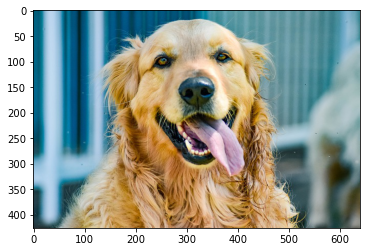

In [5]:
img_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

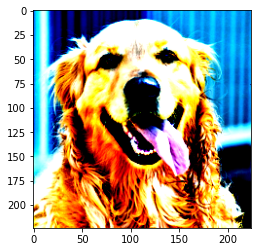

In [8]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTranform(resize, mean, std)
img_transformed = transform(img)

# (색상, 높이, 너비) -> (높이, 너비, 색상)
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)
plt.show()

In [15]:
with open('./data/imagenet_class_index.json', 'r') as img_class:
    ILSVRC_class = json.load(img_class)

ILSVRC_class['1']

['n01443537', 'goldfish']

In [17]:
class ILSVRCPredictor:
    """get label from ILSVRC data model

    Attributes:
    -----------
    class_index : dictionary
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """get label from out

        Parameters:
        -----------
        out : torch.Size([1, 1000])

        Returns:
        --------
        predicted_label_name : str
        """
        max_id = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(max_id)][1]

        return predicted_label_name

In [18]:
predictor = ILSVRCPredictor(ILSVRC_class)

img_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(img_file_path)

transform = BaseTranform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0) # (1, 3, 224, 224)

out = net(inputs)
result = predictor.predict_max(out)

print(f'입력 img 예측 결과 = {result}')

입력 img 예측 결과 = golden_retriever
